In [6]:
import pandas as pd
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import gurobipy as gp
# from gurobipy import GRB

import random
from scipy.stats import poisson,truncnorm


In [7]:
size_B = 6 # number of blocks
size_F = 3 # number of fronts
size_T = 4 # number o macro-periods
N = 3 # number of subperiods per period
S_t = {t: [s + N*(t-1)   for s in range(1,N+1)] for t in range(1,size_T+1)}
SO_t = {t: [S_t[t][0]] for t in range(1,size_T+1)}
V_j = {1,2,3,4,5,6}
F_m = {'mechanized': [1,2],'manual':[3]}

V_j = sorted(V_j)  # Convert to a sorted list
F_m = {key: sorted(value) for key, value in F_m.items()}  # Convert values to sorted lists
Blj = {1: [1,2,3,4,5,6],2:[1,2,3,4,5,6],3:[1,2,3,4,5,6]} # which front can harvest each block
Bsj = {1: [1,2,3,4],2:[1,2,3,4], 3:[2,3,4,5,6], 4:[3,4,5,6]} # blocks that can be harvested on each period


In [8]:
model = pyo.ConcreteModel()
# Sets
model.B = pyo.RangeSet(1, size_B)  # Harvesting blocks
model.F = pyo.RangeSet(1, size_F)  # Harvesting fronts
model.T = pyo.RangeSet(1, size_T)  # Macro periods
model.S = pyo.RangeSet(1, N*size_T)  # Micro-periods
model.M = pyo.Set(initialize=['mechanized','manual']) # Harvesting type (manual or mechanized)
model.Vj = pyo.Set(initialize=V_j) # Set of j's that have a fraction fl_j that can be irrigated by vinasse
model.Fm = pyo.Set(model.M, initialize=F_m) # fronts belonging to M
model.St = pyo.Set(model.T, initialize=S_t) # micro periods belong to t
model.SOt = pyo.Set(model.T, initialize=SO_t) # first micro period of each t
model.Blj = pyo.Set(model.F,initialize=Blj)
model.Bsj = pyo.Set(model.T,initialize=Bsj)


B,F,T,S,M,Vj,Fm,St,SOt = model.B, model.F, model.T, model.S, model.M, model.Vj, model.Fm, model.St, model.SOt


In [9]:
p = {1:1000,2:1500, 3:5000, 4:4000, 5:2000, 6:400}

f = {1: {'mechanized': 1,'manual':.0},2: {'mechanized':1,'manual': 0},
     3: {'mechanized': 1,'manual':.0},4: {'mechanized':1,'manual': 0},
     5: {'mechanized': 1,'manual':.0},6: {'mechanized':0,'manual': 1}}

mind = {'mechanized': {1:2000 ,2:2000,3:2000,4:2000},'manual':{1:0 ,2:0,3:0,4:400}}
maxd = {'mechanized': {1:5000 ,2:3000,3:4000,4:3000}, 'manual': {1:400  ,2:400,3:400,4:800}}

vin = {1: 15/3,2:15/3,3:30/3,4:20/3}
fi = {1: 0.9,2:1,3:0.95,4:0.9,5:0.8,6:1}
TCH = {1: 100,2:80,3:100,4:70,5:60,6:60} # 80 ton/hec na media

Nm = {1: 30,2:20,3:10}

col = {'mechanized':{1:(59),2:(79),3:(100),4:(80),5:(90),6:(1)},'manual':{1:(1),2:(1),3:(1),4:(1),5:(1),6:15}}

Ht = {'mechanized': 10, 'manual':10}
Nt = {1: 18,2:10,3:10,4:12}
Htt = 10

K = {1: 36*8*3*8, 2: 36*8*3*8,3: 36*8*3*8, 4:36*8*3*8}
transp =  {'mechanized': {1:1.5*80,2:1.5*60,3:1.5*90,4:1.5*85,5:1.5*100,6:1.5*1},'manual':{1:1,2:1,3:1,4:1,5:1,6:40}}


dist = {
    1: {1: 0,  2: 5,  3: 10, 4: 15, 5: 20, 6: 25},
    2: {1: 5,  2: 0,  3: 6,  4: 11, 5: 16, 6: 21},
    3: {1: 10, 2: 6,  3: 0,  4: 7,  5: 12, 6: 17},
    4: {1: 15, 2: 11, 3: 7,  4: 0,  5: 8,  6: 13},
    5: {1: 20, 2: 16, 3: 12, 4: 8,  5: 0,  6: 9},
    6: {1: 25, 2: 21, 3: 17, 4: 13, 5: 9,  6: 0}
}

st = {
    1: {1: 0,         2: 0.125, 3: 0.25,  4: 0.375, 5: 0.5,   6: 0.625},
    2: {1: 0.125,     2: 0,     3: 0.15,  4: 0.275, 5: 0.4,   6: 0.525},
    3: {1: 0.25,      2: 0.15,  3: 0,     4: 0.175, 5: 0.3,   6: 0.425},
    4: {1: 0.375,     2: 0.275, 3: 0.175, 4: 0,     5: 0.2,   6: 0.325},
    5: {1: 0.5,       2: 0.4,   3: 0.3,   4: 0.2,   5: 0  ,   6: 0.225},
    6: {1: 0.625,     2: 0.525, 3: 0.425, 4: 0.325, 5: 0.225, 6: 0}
} # Velocidade media de 40km/h para as distâncias. St está em horas

Np = 30
bm = {
    1: {1: 20*25, 2: 15*25, 3: 10*25, 4: 25*25, 5: 18*25, 6: 1000},  # Frente 1 (mecanizada)
    2: {1: 20*25, 2: 15*25, 3: 10*25, 4: 25*25, 5: 18*25, 6: 1000},  # Frente 2 (mecanizada)
    3: {1:100, 2:100, 3:100, 4:100, 5:100, 6: 10}         # Frente 3 (manual)
}

# mo = 100_000
# bs = 10_000
# md = 5_000

#####



# p = {}
# for j in B:
#     p[j] = np.random.normal(1000, 20)

# # not in new code
# f = {1: {'mechanized': 1,'manual':.0},2: {'mechanized':1,'manual': 0},
#      3: {'mechanized': 1,'manual':.0},4: {'mechanized':1,'manual': 0},
#      5: {'mechanized': 1,'manual':.0},6: {'mechanized':0,'manual': 1}} 

# maxd_t_offset = 100
# mind = {'mechanized': {},'manual':{}}
# maxd = {'mechanized': {},'manual':{}}
# for t in T:
#     mind['mechanized'][t] = np.random.normal(500, 50)
#     maxd['mechanized'][t] = mind['mechanized'][t] + maxd_t_offset

#     mind['manual'][t] = np.random.normal(500, 50)
#     maxd['manual'][t] = mind['manual'][t] + maxd_t_offset

# vin = {}
# for t in T:
#     vin[t] = np.random.uniform(10, 20)

# fi = {}
# for j in B:
#     fi[j] = np.random.uniform(0, 1)

# a, b = 0, np.inf
# mu, sigma = 100, 15
# TCH = {}
# for j in B:
#     TCH[j] = truncnorm.rvs( a=(a - mu) / sigma, b=(b - mu) / sigma, loc=mu, scale=sigma)

# Nm = {}
# for l in F:
#     Nm[l] = max(1, poisson.rvs(5) )

# col = {'mechanized':{}, 'manual':{}}
# for j in B:
#     col['mechanized'][j] = np.random.uniform(100, 300)
#     col['manual'][j] = np.random.uniform(100, 300)

# Ht = {'mechanized': 8, 'manual':8}
# Nt = {1: 18,2:10,3:10,4:12}
# Htt = 8

# K = {}
# for t in T:
#     K[t] = np.random.uniform(10000, 10001)

# transp =  {'mechanized': {},'manual':{}}
# for j in B:
#     transp['mechanized'][j] = np.random.uniform(100, 200)
#     transp['manual'][j] = np.random.uniform(100, 200)


# coord_min = -100.0
# coord_max =  100.0
# coords = np.random.uniform(coord_min, coord_max, size=(size_B, 2))  # Shape: (size_B, 2)

# diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]  # Shape: (size_B, size_B, 2)
# dist = np.sqrt(np.sum(diff ** 2, axis=2))  # Shape: (size_B, size_B)
# np.fill_diagonal(dist, 0)  # type: ignore # Set diagonal to 0 (distance to self)

# st = dist/40

# Np = size_F
# bm = {}
# for l in F:
#     bm[l] = {}
#     for j in B:
#         bm[l][j] = np.random.uniform(0, 10)

mo = 10
bs = 5
md = 1



#####

pa = 20

min_window = 1
max_window = size_T
harvest_window_j = {}
for j in B:
    window_length_j = random.randint(min_window, max_window)
    start_j = random.randint(1, size_T - window_length_j + 1)
    end_j = start_j + window_length_j - 1
    harvest_window_j[j] = (start_j, end_j)

ATR_jt = np.zeros( (size_B, size_T) )
for j in B:
    start_j, end_j = harvest_window_j[j]
    for t in T:
        if start_j <= t <= end_j:
            # ATR_jt[j-1, t-1] = np.random.normal(10, 1)
            ATR_jt[j-1, t-1] = np.random.normal(10, 1)

In [10]:
model.p = pyo.Param(model.B,initialize=p, within=NonNegativeReals)  # Estimated production of the blocks (in tons)


def init_f(model,j,m):
    return f[j][m]
model.f = pyo.Param(model.B, model.M,initialize=init_f, within=NonNegativeReals)  # Fraction of the production of j using m

def init_mind(model,m,j):
    return mind[m][j]
model.mind = pyo.Param(model.M, model.T,initialize=init_mind, within=NonNegativeReals)  # Sugarcane meal demand range (min)

def init_maxd(model,m,j):
    return maxd[m][j]
model.maxd = pyo.Param(model.M, model.T,initialize=init_maxd, within=NonNegativeReals)  # Sugarcane meal demand range (max)


model.vin = pyo.Param(model.T, initialize=vin, within=NonNegativeReals)  # Minimum amount of area to be released
model.fi = pyo.Param(model.B,initialize=fi ,within=NonNegativeReals)  # Fraction of a block that can be irrigated by vinasse
model.TCH = pyo.Param(model.B,initialize=TCH, within=NonNegativeReals)  # Productivity of j (in tons per hec)

def init_Nm(model,l):
    return Nm[l]
model.Nm = pyo.Param(model.F,initialize=init_Nm ,within=NonNegativeIntegers)  # Machines in front l

def init_col(model,m,j):
    return col[m][j]
model.col = pyo.Param(model.M,model.B,initialize=init_col, within=NonNegativeReals)  # Harvesting capacity of block j (tons/hour)
model.Ht = pyo.Param(model.M,initialize=Ht ,within=NonNegativeReals)  # Capacity (continuous hours/day) of the machines m
model.Nt = pyo.Param(model.T,initialize=Nt,within=NonNegativeIntegers)  # Fleet of homogeneous trucks
model.K = pyo.Param(model.T,initialize=K ,within=NonNegativeReals)  # Working availability for the fleet of vehicles for each t

def init_transp(model,m,j):
    return transp[m][j]
model.transp = pyo.Param(model.M,model.B,initialize=init_transp, within=NonNegativeReals)  # Transport capacity (tons/hour) of the block j

def init_st(model,i,j):
    if i != j:
        return st[i][j]
        # return st[i-1][j-1]
    else:
        return 0

model.st = pyo.Param(model.B, model.B, initialize=init_st, within=NonNegativeReals)  # Displacement time from block i to j

def init_dist(model,i,j):
    if i !=j:
        return dist[i][j]
        # return dist[i-1][j-1]
    else:
        return 0
model.dist = pyo.Param(model.B, model.B,initialize=init_dist, within=NonNegativeReals)  # Distance between blocks

def init_bm(model,l,j):
    return bm[l][j]
model.bm = pyo.Param(model.F, model.B,initialize=init_bm, within=NonNegativeReals)  # Minimum amount to be harvested from each block from each front

model.Htt = pyo.Param(initialize=Htt,within=NonNegativeReals )  # Capacity (continuous hours per day) for the trucks
model.Np = pyo.Param(initialize=Np,within=NonNegativeIntegers)  # Number of vehicles with a flatbed trailer
model.mo = pyo.Param(initialize=mo, within=NonNegativeReals)  # Opportunity cost of a non-milled ton of sugarcane when mind_{mt} is not met
model.bs = pyo.Param(initialize=bs, within=NonNegativeReals)  # Opportunity cost of a ton of sugarcane left unharvested
model.md = pyo.Param(initialize=md, within=NonNegativeReals)  # Unit cost of the distance travelled by the front moving between blocks


p,Blj,Bsj,f,mind,maxd,vin,fi,TCH,Nm,col,Ht,Nt,K,transp,st,dist,bm,Htt,Np,mo,bs,md = model.p, model.Blj, model.Bsj, model.f, model.mind, model.maxd, model.vin, model.fi, model.TCH, model.Nm, model.col, model.Ht, model.Nt, model.K, model.transp, model.st, model.dist, model.bm, model.Htt, model.Np, model.mo, model.bs, model.md


In [11]:
# Decision Variables
def x_bounds(model,l, j,s):
    return (0, model.p[j])

model.x = pyo.Var(model.F, model.B, model.S, within=NonNegativeReals,bounds=x_bounds)
model.y = pyo.Var(model.F, model.B, model.S, within=Binary)
model.z = pyo.Var(model.F, model.B, model.B, model.S, within=Binary)

def wm_bounds(model, m, j):
    return (0, model.mind[m, j])
model.wm = Var(model.M, model.T, bounds=wm_bounds)

def wb_bounds(model, j):
    return (0, model.p[j])
model.wb = Var(model.B, bounds=wb_bounds)
x,y,z,wm,wb = model.x,model.y,model.z,model.wm,model.wb


In [12]:

#2
def meet_minimum_demand(model,list_of_constraints,t,m):
    """
    Constraint to ensure that the production and milling lost meets the minimum demand. (junqueira, morabito)

    Args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        t (int): The current macro-period.
        m (str): The type of harvesting (manual or mechanized).

    Returns:
        Constraint: "Ensures that the sum of production by all fronts and milling lost is
        greater than or equal to the minimum demand for each harvesting type during each period." (junqueira, morabito)
    """

    model.minimum_demand_list.add(expr=(sum(x[l, j, s] for s in St[t] for j in B for l in Fm[m]) + wm[m, t] >= mind[m, t]))

#3
def stop_at_maximum_demand(model,list_of_constraints,t,m):
    """
    Constraint to ensure that the production does not exceed the maximum demand. (junqueira, morabito)

    Args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        t (int): The current macro-period.
        m (str): The type of harvesting (manual or mechanized).

    Returns:
        Constraint: "Ensures that the sum of production by all fronts does not exceed the
        maximum demand for each harvesting type during each period." (junqueira, morabito)
    """

    model.maximum_demand_list.add(expr=(sum(x[l, j, s] for s in St[t] for j in B for l in Fm[m])  <= maxd[m, t]))

#4
def limit_harvest_and_transport(model,list_of_constraints,j,m):
    """
    Constraint to limit the harvest and transport to the availability of raw material in the block (junqueira, morabito)

    Args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        t (int): The current macro-period.
        m (str): The type of harvesting (manual or mechanized).

    Returns:
        Constraint: "limit the harvest and transport to the availability of raw material in the block and are, therefore, related to the field production, considering the kind of harvesting of the front and the block."(junqueira, morabito)
    """
    model.limit_harvest_and_transpot_list.add(expr=(sum(x[l,j,s] for s in S for l in Fm[m]) + wb[j] == p[j]*f[j,m]))

#5
def minimum_amount_of_vinasse(model,list_of_constraints,t):
    """
    Constraint to Determine the minimum amount of vinasse area to be released on the macro periods (junqueira, morabito)

    Args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        t (int): The current macro-period.

    returns:
        Constraint: "determine the minimum amount of vinasse area to be released at each macro-period t, taking into account the amount of irrigable area in the block" (Junqueira, Morabito)
    """

    model.minimum_amount_of_vinasse_list.add(expr=(sum((x[l,j,s]/TCH[j])*fi[j] for s in St[t] for l in F for j in Vj) >= vin[t]))

#6
def limit_harvesting_capacity(model,list_of_constraints,t,m,l):
    """
    Constraint to relate the time spent in producing harvest resources and the time spent displacing the equipament and the capacity K_t, the working availabily of the fleet for each macro-period

    Args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        t (int): The current macro-period.
        m (str): The type of harvesting (manual or mechanized).
        l (int): the harvesting front

    returns:
        Constraint: "relate the time spent producing harvest resources, as well as the time spent on transporting equipment from one area to another with the total time available in the period. The resource production time takes into account the block performance characteristics, as well as the agronomic suitability for the harvest during the period. The time for transporting the equipment, when moving from one area to another, takes into account the time spent on this move, as well as the number of vehicles with a flatbed trailer available for this operation." (Junqueira, Morabito)

    """

    model.limit_harvesting_capacity_list.add(expr=( sum(((24)/(col[m,j]*Nm[l]*Ht[m]))*x[l,j,s] for s in St[t] for j in B) + sum( (Nm[l]/Np)*st[i,j]*z[l,i,j,s] for s in St[t] for j in B for i in B) <= K[t]))

#7
def limit_transport_capacity(model,list_of_constraints,t):
    """
    Constraint to limit the transportation resources

    args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        t (int): The current macro-period.

    returns:
        constraint: "ddress the trans- portation resources, whose production potential is considered per block. In this case, the time spent on moving the front is not inserted because, when changing areas, these resources can either transport the production of the areas under operation, or they are idle consuming stock on the roads at the agroindustrial unit" (Junqueira, Morabito)
    """
    model.limit_transport_capacity_list.add(expr=(sum((24/(transp[m,j]*Nt[t]*Htt))*x[l,j,s] for s in St[t] for j in B for m in M for l in Fm[m]) <= K[t]))

#8
def limit_production_to_capacity(model,list_of_constraints,t,s,j,m,l):
    """
    Constraint to couple x and y

    args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        m (str): The type of harvesting (manual or mechanized).
        j (int): The harvesting block
        l (int): the harvesting front
        s (int): The current micro-period.

    Returns:
        Constraint:"ensure that when there is production in block j by the harvesting front l during micro-period s, the front is positioned at the same place and time. In the same way, for the opposite situation, when the front is not positioned, there is no production of the block. It is important to mention that the upper limit of x_ljs was considered as the minimum between the harvesting and transport capacity" (Junqueira, Morabito)

    """
    # print((transp[m,j]*Nt[t]*Htt)/24)
    # print(((col[m,j]*Nm[l]*Ht[m])/24))
    # print(min(((transp[m,j]*Nt[t]*Htt)/24),((col[m,j]*Nm[l]*Ht[m])/24)))
    model.limit_production_to_capacity_list.add(expr=(x[l,j,s]<= min((transp[m,j]*Nt[t]*Htt)/24,(col[m,j]*Nm[l]*Ht[m])/24)*K[t]*y[l,j,s]))

#9
def floor_of_production_capacity(model,list_of_constraints,l,j,s):
    """
    Constraint to define the minum lot size

    args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        m (str): The type of harvesting (manual or mechanized).
        j (int): The harvesting block
        l (int): the harvesting front
        s (int): The current micro-period.

    Returns:
        Constraint:Constraint to define the minum lot size (Junqueira, Morabito)
    """

    model.floor_of_production_capacity_list.add(expr=(x[l,j,s] >= bm[l,j]*(y[l,j,s] - y[l,j,s-1])))

#10
def harvest_all_blocks(model,list_of_constraints,t,s,l):
    """
    Constraint to make at least one block to be visited on micro period s and that the block is visited in the correct time window.

    args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        l (int): the harvesting front
        s (int): The current micro-period.

    returns:
        Constraint: "ensure that front l will be in only one block j during micro-period s. Using parameterBs jt , these constraints impose that the harvest occurs in blocks j allowed by the time windows,that is, during macro-periods t. In addition, using parameterBl jl , these equations define blocks j that a harvesting front l can harvest. This happens when it is necessary to sectorize one of the fronts. It is worth highlighting that=y 0ljs are previously fixed for micro-periods s that are out of the time window of block j (Bs )jt , as well as for those fronts l that cannot be harvested (Bl )jl" (Junqueira, morabito)
    """
    valid_blocks = set(value for value in Bsj[t] if value in Blj[l])
    model.harvest_all_blocks_list.add(expr=(sum(y[l,j,s] for j in valid_blocks) == 1))

#11
def consistent_movement_on_period_s_minus(model,list_of_constraints,s,l,i):
    """
    Constraint to define the movement of the front in micro-period s-1

    args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        l (int): the harvesting front
        s (int): The current micro-period
        j (int): The harvesting block

    returns:
        Constraint: togheter with constraint #12 "define the movement of the front by variablez lijs , consistent with the positions of the front during micro-period s (yljs ) and during the previous micro- period s-1 (ylis 1 )." (Junqueira, Morabito)

    returns:
    """
    model.consistent_movement_on_period_s_minus_list.add(expr=(sum(z[l,i,j,s] for j in B) == y[l,i,s-1]))

#12
def consistent_movement_on_period_s(model,list_of_constraints,s,l,j):
    """
    Constraint to define the movement of the front in micro-period s-1

    args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        l (int): the harvesting front
        s (int): The current micro-period
        j (int): The harvesting block

    returns:
        Constraint: togheter with constraint #12 "define the movement of the front by variablez lijs , consistent with the positions of the front during micro-period s (yljs ) and during the previous micro- period s-1 (ylis 1 )." (Junqueira, Morabito)

    returns:
    """
    model.consistent_movement_on_period_s_list.add(expr=(sum(z[l,i,j,s] for i in B) == y[l,j,s]))

#13
def idle_micro_period(model,list_of_constraints,s,j,l):
    """
    Constraint to define that the idle micro-periods only occur at the end of the macro-period

    args:
        model (ConcreteModel): The Pyomo model instance containing all sets, parameters, and variables.
        l (int): the harvesting front
        s (int): The current micro-period
        j (int): The harvesting block
    """

    model.idle_micro_period_list.add(expr=(y[l,j,s-1] >= y[l,j,s]))


In [13]:
model.objective = Objective(expr=( \
    mo*sum(wm[m, t] for m in M for t in T) + \
    bs*sum(wb[j] for j in B) + \
    md*sum(dist[i, j] * z[l, i, j,s] for l in F for i in B for j in B for s in S) + \
    pa*sum(ATR_jt[j-1,t-1] * sum(x[l,j,s] for l in F for s in S) for j in B for t in T) ), sense=minimize)
    # pa*sum(ATR_jt[j-1,t-1] for j in B for t in T) ), sense=minimize)

# Fixando valores impossiveis de y
for j in B:
  for t in T:
    for l in F:
      if not j in set(value for value in Bsj[t] if value in Blj[l]):
        for s in St[t]:
            y[l,j,s].fix(0)

#2 & 3
model.minimum_demand_list = ConstraintList()
model.maximum_demand_list = ConstraintList()
for t in T:
    for m in M:
        meet_minimum_demand(model,model.minimum_demand_list,t,m)
        stop_at_maximum_demand(model,model.maximum_demand_list,t,m)

model.limit_harvest_and_transpot_list = ConstraintList()
# 4
for j in B:
    for m in M:
        limit_harvest_and_transport(model,model.limit_harvest_and_transpot_list,j,m)

model.minimum_amount_of_vinasse_list = ConstraintList()
#5
for t in T:
    minimum_amount_of_vinasse(model,model.minimum_amount_of_vinasse_list,t)

model.limit_harvesting_capacity_list = ConstraintList()
#6
for t in T:
    for m in M:
        for l in Fm[m]:
            limit_harvesting_capacity(model,model.limit_harvesting_capacity_list,t,m,l)

model.limit_transport_capacity_list = ConstraintList()
#7
for t in T:
    limit_transport_capacity(model,model.limit_transport_capacity_list,t)


model.limit_production_to_capacity_list = ConstraintList()
#8
for t in T:
    for s in St[t]:
        for j in B:
            for m in M:
                for l in Fm[m]:
                    limit_production_to_capacity(model,model.limit_production_to_capacity_list,t,s,j,m,l)

model.floor_of_production_capacity_list = ConstraintList()
#9
for s in S:
  if s>1:
    for l in F:
      for j in B:
        floor_of_production_capacity(model,model.floor_of_production_capacity_list,l,j,s)


model.harvest_all_blocks_list = ConstraintList()
#10
for t in T:
   for s in St[t]:
      for l in F:
        harvest_all_blocks(model,model.harvest_all_blocks_list,t,s,l)


model.consistent_movement_on_period_s_minus_list = ConstraintList()
#11
for s in S:
    if s > 1:
       for l in F:
           for i in B:
                consistent_movement_on_period_s_minus(model,model.consistent_movement_on_period_s_minus_list,s,l,i)

model.consistent_movement_on_period_s_list = ConstraintList()
#12
for s in S:
    for l in F:
        for j in B:
            consistent_movement_on_period_s(model,model.consistent_movement_on_period_s_list,s,l,j)

model.idle_micro_period_list = ConstraintList()
#13
for t in T:
    for s in St[t] - SOt[t]:
        for j in B:
          for l in F:
            idle_micro_period(model,model.idle_micro_period_list,s,j,l)

In [14]:
# Solve the model again
opt = pyo.SolverFactory('gurobi')

# Executar a solução novamente se necessário
results = opt.solve(model, tee=True)

# Print the objective value if the problem was solved successfully
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
  print("objective ",model.objective())


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-13
Read LP format model from file C:\Users\Alex\AppData\Local\Temp\tmp6xu4zyft.pyomo.lp
Reading time = 0.02 seconds
x1: 1056 rows, 1680 columns, 6380 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1056 rows, 1680 columns and 6380 nonzeros
Model fingerprint: 0x199fc731
Variable types: 231 continuous, 1449 integer (1449 binary)
Coefficient statistics:
  Matrix range     [8e-04, 7e+06]
  Objective range  [5e+00, 8e+02]
  Bounds range     [1e+00, 5e+03]
  RHS range        [1e+00, 7e+03]
Presolve removed 875 rows and 1462 columns
Presolve time: 0.02s
Presolved: 181 rows, 218 columns, 952 nonzeros
Variable types: 99 continuous, 119 integer (119 binary)

Root relaxation: objective

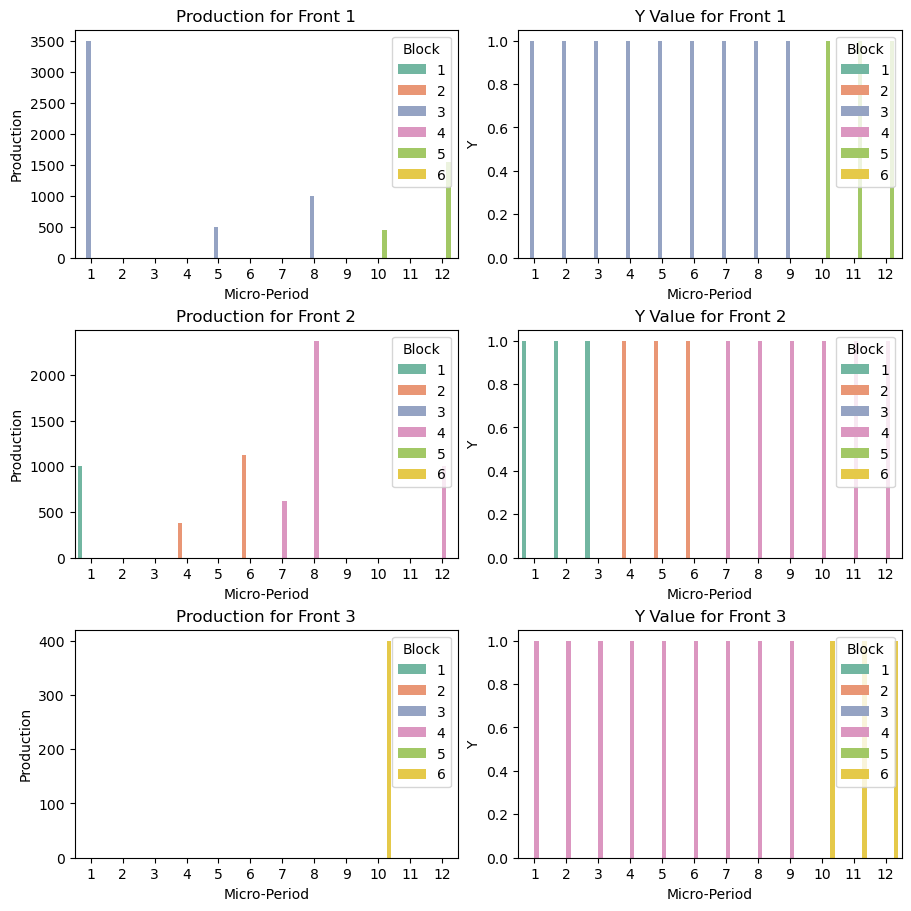

In [15]:
fronts = []
blocks = []
micro_periods = []
productions = []
y_lista = []

for l in F:  # Assuming F is the set of fronts
    for j in B:  # Assuming B is the set of blocks
        for s in S:  # Assuming S is the set of micro-periods
            fronts.append(l)
            blocks.append(j)
            micro_periods.append(s)
            productions.append(model.x[l, j, s].value)  # Extracting the value of each x[l, j, s]
            y_lista.append(model.y[l, j, s].value)


df_X = pd.DataFrame({
    'Front': fronts,
    'Block': blocks,
    'Micro-Period': micro_periods,
    'Production': productions,
    'Y': y_lista
})


# Criar subplots: cada frente terá uma linha, cada linha terá 2 gráficos
fig, axs = plt.subplots(nrows=len(model.F), ncols=2, figsize=(9, 3 * 3), constrained_layout=True)

# Iterar por cada frente
for i, front in enumerate(model.F):
    front_data = df_X[df_X['Front'] == front]

    # Gráfico de barras para 'Production'
    sns.barplot(x='Micro-Period', y='Production', hue='Block', palette='Set2', data=front_data, ax=axs[i][0])
    axs[i][0].set_title(f'Production for Front {front}')
    axs[i][0].set_xlabel('Micro-Period')
    axs[i][0].set_ylabel('Production')
    axs[i][0].legend(title='Block', loc='upper right')

    # Gráfico de dispersão para 'Y'
    sns.barplot(x='Micro-Period', y='Y', hue='Block', palette='Set2', data=front_data, ax=axs[i][1])
    axs[i][1].set_title(f'Y Value for Front {front}')
    axs[i][1].set_xlabel('Micro-Period')
    axs[i][1].set_ylabel('Y')
    axs[i][1].legend(title='Block', loc='upper right')

# plt.savefig('apresentação/imagens/resultado_inst_1.png')
plt.show()